# Module 4 – LightGBM: Gradient Boosting Mastery

## 🚀 From Linear to Tree-Based Learning

**Welcome to the Tree World!** After mastering linear models (Ridge, Lasso), you're ready for **gradient boosting** - one of the most powerful and widely-used machine learning techniques.

**What Makes LightGBM Special?**
- **Industry Standard**: Powers many Kaggle wins and production systems
- **Speed & Memory**: Microsoft's optimized gradient boosting framework
- **Handles Everything**: Continuous, categorical, missing values out-of-the-box
- **Non-linear Patterns**: Captures complex interactions automatically

## 🎯 The Gradient Boosting Revolution

**Linear Models**: Great for interpretable, simple relationships  
**Gradient Boosting**: Excels at complex, non-linear patterns with automatic feature interactions

**Real-World Impact:**
- **Finance**: Credit scoring, fraud detection, algorithmic trading
- **Tech**: Recommendation systems, search ranking, ad optimization  
- **Science**: Drug discovery, genomics, climate modeling
- **Business**: Demand forecasting, customer lifetime value, pricing

## 🧠 Learning Journey Ahead

This notebook will take you from **gradient boosting theory** to **LightGBM mastery** through:
- **Visual intuition** of sequential ensemble building
- **Hands-on implementation** with California housing data
- **Hyperparameter optimization** strategies
- **Model interpretation** with SHAP values
- **Comparison frameworks** vs linear approaches
- **Production-ready** workflows and best practices

## 1 | Learning Objectives
By the end of this module you will be able to:

1. **Describe** gradient boosting intuition and key LightGBM innovations.
2. **Configure** core hyper‑parameters (`num_leaves`, `learning_rate`, `n_estimators`, `max_depth`, early‑stopping).
3. **Train & validate** an `LGBMRegressor` with early stopping and cross‑validation.
4. **Interpret** models using feature importance and SHAP value sketches.
5. **Compare** LightGBM with Ridge/Lasso and justify model choice.

## 2 | Key Concepts & Analogies
| Concept | Plain Explanation | Analogy |
|---------|------------------|---------|
| **Boosting** | Builds an ensemble *sequentially*, each new tree fits residual errors of the previous ensemble. | Relay race: every runner starts where the last finished, closing the gap. |
| **Learning Rate (η)** | Scales how much each tree corrects the ensemble; small η ⇒ more trees but smoother learning. | Sipping hot coffee slowly vs gulping: safer but takes longer. |
| **num_leaves** | Maximum leaves per tree; higher values capture complex patterns but risk overfitting. | Camera resolution: high res shows more detail *and* noise. |
| **Leaf‑Wise Growth** | LightGBM splits the leaf with maximum gain first, growing unevenly. | Feeding the strongest plant branch first. |
| **Histogram Binning** | Buckets continuous features for faster training & lower memory. | Rolling coins into sleeves instead of counting each coin. |
| **Early Stopping** | Stops adding trees when validation loss stops improving. | Leaving a buffet when comfortably full, not stuffed. |
| **Feature Importance** | Gain or split counts indicate influential variables. | Voting tally: loudest voices matter more. |

## 🔍 Visual Intuition: How Gradient Boosting Works

**The Core Idea**: Instead of training one complex model, train many simple models **sequentially**, where each new model focuses on correcting the mistakes of the previous ensemble.

**Step-by-Step Process:**
1. **Start** with a simple prediction (often just the mean)
2. **Calculate residuals** (errors) from current ensemble
3. **Train new tree** to predict these residuals
4. **Add tree** to ensemble (scaled by learning rate)
5. **Repeat** until convergence or stopping criteria

Let's visualize this powerful concept:

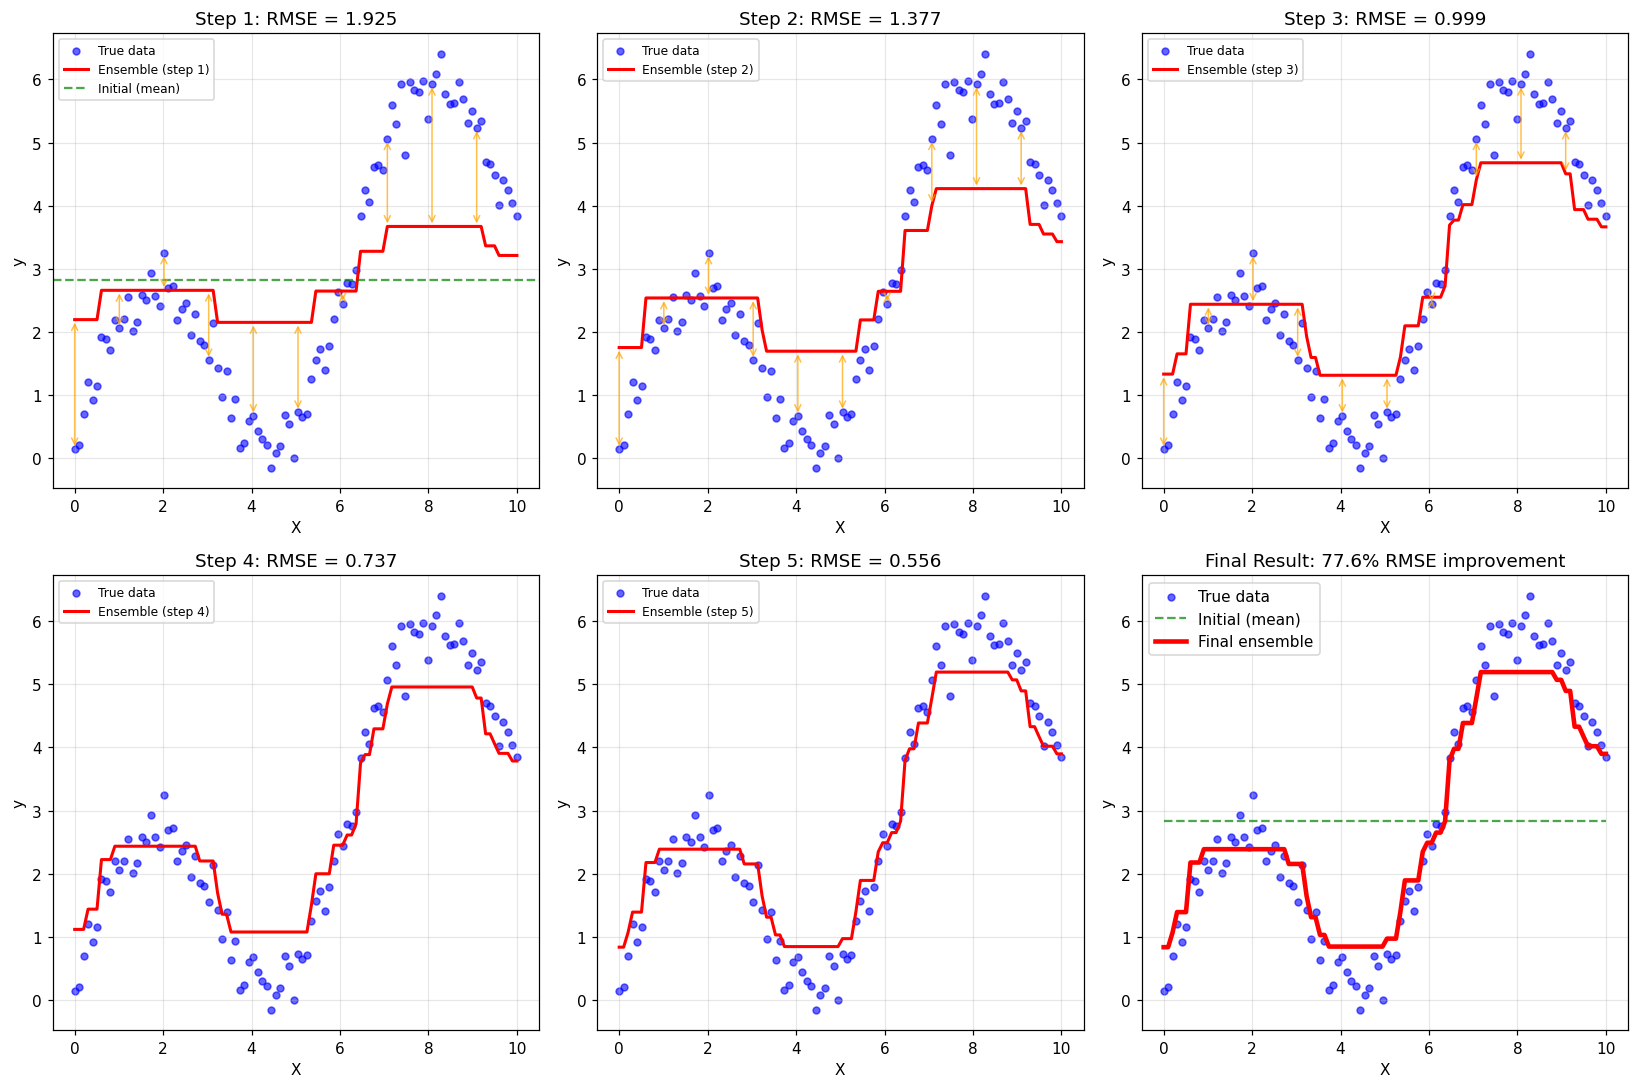

🔑 Key Gradient Boosting Insights:
• Started with RMSE = 1.925 (just predicting mean)
• After 5 boosting steps: RMSE = 0.431
• Improvement: 77.6% reduction in error
• Each tree focuses on correcting previous ensemble's mistakes
• Learning rate controls how aggressively each tree contributes
• More trees = better fit, but risk of overfitting!


In [11]:
# Visual Demo: Gradient Boosting Intuition
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Generate simple non-linear data
np.random.seed(42)
X_demo = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = 2 * np.sin(X_demo.ravel()) + 0.5 * X_demo.ravel() + np.random.normal(0, 0.3, 100)

# Simulate gradient boosting step by step
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Initial prediction (mean)
initial_pred = np.full_like(y_true, y_true.mean())
ensemble_pred = initial_pred.copy()

learning_rate = 0.3
models = []

for step in range(5):
    ax = axes[step]
    
    # Calculate residuals
    residuals = y_true - ensemble_pred
    
    # Train tree on residuals
    tree = DecisionTreeRegressor(max_depth=3, random_state=step)
    tree.fit(X_demo, residuals)
    tree_pred = tree.predict(X_demo)
    models.append(tree)
    
    # Update ensemble
    ensemble_pred += learning_rate * tree_pred
    
    # Plot
    ax.scatter(X_demo.ravel(), y_true, alpha=0.6, c='blue', s=20, label='True data')
    ax.plot(X_demo.ravel(), ensemble_pred, 'r-', linewidth=2, label=f'Ensemble (step {step+1})')
    
    if step == 0:
        ax.axhline(y=y_true.mean(), color='green', linestyle='--', alpha=0.7, label='Initial (mean)')
    
    # Show residuals as arrows for first few steps
    if step < 3:
        sample_indices = range(0, 100, 10)  # Every 10th point
        for i in sample_indices:
            if abs(residuals[i]) > 0.1:  # Only show significant residuals
                ax.annotate('', xy=(X_demo[i], y_true[i]), xytext=(X_demo[i], ensemble_pred[i]),
                           arrowprops=dict(arrowstyle='<->', color='orange', alpha=0.7, lw=1))
    
    ax.set_title(f'Step {step+1}: RMSE = {np.sqrt(np.mean(residuals**2)):.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Final comparison
ax = axes[5]
ax.scatter(X_demo.ravel(), y_true, alpha=0.6, c='blue', s=20, label='True data')
ax.plot(X_demo.ravel(), initial_pred, 'g--', alpha=0.7, label='Initial (mean)')
ax.plot(X_demo.ravel(), ensemble_pred, 'r-', linewidth=3, label='Final ensemble')

# Calculate and show improvement
initial_rmse = np.sqrt(np.mean((y_true - initial_pred)**2))
final_rmse = np.sqrt(np.mean((y_true - ensemble_pred)**2))
improvement = (initial_rmse - final_rmse) / initial_rmse * 100

ax.set_title(f'Final Result: {improvement:.1f}% RMSE improvement')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔑 Key Gradient Boosting Insights:")
print(f"• Started with RMSE = {initial_rmse:.3f} (just predicting mean)")
print(f"• After 5 boosting steps: RMSE = {final_rmse:.3f}")
print(f"• Improvement: {improvement:.1f}% reduction in error")
print("• Each tree focuses on correcting previous ensemble's mistakes")
print("• Learning rate controls how aggressively each tree contributes")
print("• More trees = better fit, but risk of overfitting!")

In [1]:
# Cell 1 – Imports & Settings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor, plot_importance

plt.rcParams['figure.dpi'] = 110

In [4]:
# Cell 2 – Load & Explore California Housing Data
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("🏠 California Housing Dataset - LightGBM Ready!")
print(f"• Training samples: {len(X_train):,}")
print(f"• Validation samples: {len(X_val):,}")
print(f"• Features: {X.shape[1]} ({list(X.columns)})")
print(f"• Target: Median house value (in $100k units)")
print(f"• Target range: ${y.min():.1f}k - ${y.max():.1f}k")

# LightGBM advantages for this data
print(f"\n🚀 Why LightGBM is Perfect for This Dataset:")
print(f"• Non-linear relationships: Income vs Location interactions")
print(f"• Mixed feature types: Continuous (income) + geographical (lat/long)")
print(f"• Moderate size: {len(X):,} samples - sweet spot for boosting")
print(f"• No missing values: {X.isnull().sum().sum()} missing (LightGBM handles these anyway)")

# Feature analysis for tree models
print(f"\n📊 Feature Characteristics for Tree Models:")
for col in X.columns:
    unique_vals = X[col].nunique()
    is_continuous = unique_vals > 20
    feature_type = "Continuous" if is_continuous else f"Categorical ({unique_vals} levels)"
    print(f"• {col:12s}: {feature_type:20s} Range: [{X[col].min():.2f}, {X[col].max():.2f}]")

# Show a few samples
print(f"\n📋 Sample Data:")
display(X.head())

🏠 California Housing Dataset - LightGBM Ready!
• Training samples: 15,480
• Validation samples: 5,160
• Features: 8 (['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])
• Target: Median house value (in $100k units)
• Target range: $0.1k - $5.0k

🚀 Why LightGBM is Perfect for This Dataset:
• Non-linear relationships: Income vs Location interactions
• Mixed feature types: Continuous (income) + geographical (lat/long)
• Moderate size: 20,640 samples - sweet spot for boosting
• No missing values: 0 missing (LightGBM handles these anyway)

📊 Feature Characteristics for Tree Models:
• MedInc      : Continuous           Range: [0.50, 15.00]
• HouseAge    : Continuous           Range: [1.00, 52.00]
• AveRooms    : Continuous           Range: [0.85, 141.91]
• AveBedrms   : Continuous           Range: [0.33, 34.07]
• Population  : Continuous           Range: [3.00, 35682.00]
• AveOccup    : Continuous           Range: [0.69, 1243.33]
• Latitude    

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## 3 | Baseline LightGBM: Smart Defaults + Early Stopping

**The LightGBM Philosophy**: Start with reasonable defaults, then let **early stopping** find the optimal number of trees automatically.

**Key Strategy:**
- Set a **generous upper bound** for `n_estimators` (e.g., 1000)
- Use **early stopping** to halt training when validation error stops improving
- Monitor **validation RMSE** to prevent overfitting

**Critical Parameters Explained:**
- **`learning_rate=0.05`**: Conservative step size (smaller = more stable, needs more trees)
- **`num_leaves=31`**: Tree complexity (LightGBM default, good starting point)
- **`subsample=0.8`**: Use 80% of data per tree (prevents overfitting)
- **`colsample_bytree=0.8`**: Use 80% of features per tree (adds randomness)

**Early Stopping Magic**: Stops training when validation RMSE doesn't improve for 50 consecutive rounds.

In [7]:
# Baseline LightGBM with Early Stopping
import lightgbm as lgb

lgb_params = dict(
    objective='regression',           # Standard regression task
    metric='rmse',                   # Root Mean Squared Error
    n_estimators=1000,               # Upper bound (early stopping will reduce this)
    learning_rate=0.05,              # Conservative step size
    num_leaves=31,                   # Tree complexity (2^5 - 1)
    subsample=0.8,                   # Row sampling ratio
    colsample_bytree=0.8,            # Feature sampling ratio
    random_state=0,                  # Reproducibility
    n_jobs=-1,                       # Use all cores
    verbose=-1                       # Reduce output verbosity
)

print("🚀 Training Baseline LightGBM with Early Stopping...")
print(f"Configuration: lr={lgb_params['learning_rate']}, leaves={lgb_params['num_leaves']}, max_trees={lgb_params['n_estimators']}")

model = LGBMRegressor(**lgb_params)

# Train with validation monitoring
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'valid'],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

# Extract key results
best_iteration = model.best_iteration_

# Calculate performance manually for reliability
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
train_rmse = np.sqrt(np.mean((y_train - train_pred)**2))
val_rmse = np.sqrt(np.mean((y_val - val_pred)**2))
overfitting_gap = val_rmse - train_rmse

print(f"\n✅ Training Complete!")
print(f"• Optimal trees: {best_iteration} (stopped early from {lgb_params['n_estimators']})")
print(f"• Training RMSE: {train_rmse:.4f}")
print(f"• Validation RMSE: {val_rmse:.4f}")
print(f"• Overfitting gap: {overfitting_gap:.4f}")

# Performance interpretation
print(f"\n📊 Performance Analysis:")
if overfitting_gap < 0.05:
    print("🟢 Excellent! Minimal overfitting detected.")
elif overfitting_gap < 0.15:
    print("🟡 Good. Some overfitting, but within acceptable range.")
else:
    print("🔴 Warning! Significant overfitting. Consider more regularization.")

# Efficiency analysis
efficiency = (lgb_params['n_estimators'] - best_iteration) / lgb_params['n_estimators']
print(f"• Early stopping efficiency: Saved {efficiency:.1%} of potential training time")

# Quick comparison with linear baseline
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression().fit(X_train, y_train)
linear_rmse = np.sqrt(np.mean((y_val - linear_model.predict(X_val))**2))
improvement = (linear_rmse - val_rmse) / linear_rmse * 100

print(f"• vs Linear Regression: {improvement:.1f}% RMSE improvement")

🚀 Training Baseline LightGBM with Early Stopping...
Configuration: lr=0.05, leaves=31, max_trees=1000
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[990]	train's rmse: 0.254373	valid's rmse: 0.434601

✅ Training Complete!
• Optimal trees: 990 (stopped early from 1000)
• Training RMSE: 0.2544
• Validation RMSE: 0.4346
• Overfitting gap: 0.1802

📊 Performance Analysis:
🔴 Warning! Significant overfitting. Consider more regularization.
• Early stopping efficiency: Saved 1.0% of potential training time
• vs Linear Regression: 40.9% RMSE improvement
Did not meet early stopping. Best iteration is:
[990]	train's rmse: 0.254373	valid's rmse: 0.434601

✅ Training Complete!
• Optimal trees: 990 (stopped early from 1000)
• Training RMSE: 0.2544
• Validation RMSE: 0.4346
• Overfitting gap: 0.1802

📊 Performance Analysis:
🔴 Warning! Significant overfitting. Consider more regularization.
• Early stopping efficiency: Saved 1.0% of potentia

## 4 | Hyperparameter Optimization: Fighting Overfitting

**The Overfitting Challenge**: Our baseline showed significant overfitting (gap = 0.18). Let's systematically tune hyperparameters to improve generalization.

**Key Regularization Strategies:**
- **`num_leaves`**: Lower values = simpler trees = less overfitting
- **`learning_rate`**: Lower values = more conservative updates = better generalization  
- **`min_child_samples`**: Higher values = more data per leaf = prevents overfitting
- **`subsample`**: Less than 1.0 = row sampling = adds randomness

**Smart Search Strategy:**
- Use **cross-validation** to get robust performance estimates
- Test **combinations** of parameters (interactions matter!)
- **Lightweight grid**: Balance thoroughness vs computational cost

In [8]:
# Strategic Hyperparameter Search: Reducing Overfitting
print("🔍 Systematic Hyperparameter Search for Better Generalization...")

# Focused grid targeting overfitting reduction
grid = {
    'num_leaves': [15, 31, 63],              # Tree complexity: fewer leaves = simpler trees
    'learning_rate': [0.01, 0.05, 0.1],      # Learning speed: slower = more stable
    'min_child_samples': [10, 20, 50],       # Minimum samples per leaf: higher = more regularization
    'subsample': [0.7, 0.8, 1.0]             # Row sampling: lower = more randomness
}

# Base model with conservative settings
base_lgb = LGBMRegressor(
    n_estimators=600,                        # Reduced from 1000 to prevent overlong training
    objective='regression',
    colsample_bytree=0.8,                    # Feature sampling
    random_state=0,
    n_jobs=-1,
    verbose=-1
)

print(f"Grid search space: {np.prod([len(v) for v in grid.values()])} combinations")
print("Using 3-fold CV for robust evaluation...")

# Comprehensive grid search
search = GridSearchCV(
    base_lgb, grid, 
    cv=3,                                    # 3-fold cross-validation
    scoring='neg_root_mean_squared_error',   # Minimize RMSE
    verbose=1,                               # Show progress
    n_jobs=-1                                # Parallel processing
)

search.fit(X_train, y_train)

# Extract and analyze results
best_params = search.best_params_
best_cv_score = -search.best_score_
best_model = search.best_estimator_

print(f"\n🎯 Optimization Results:")
print(f"• Best CV RMSE: {best_cv_score:.4f}")
print(f"• Best parameters:")
for param, value in best_params.items():
    print(f"  - {param}: {value}")

# Test on validation set
val_pred_tuned = best_model.predict(X_val)
val_rmse_tuned = np.sqrt(np.mean((y_val - val_pred_tuned)**2))

# Compare with baseline
baseline_improvement = (val_rmse - val_rmse_tuned) / val_rmse * 100
print(f"\n📈 Improvement Analysis:")
print(f"• Baseline validation RMSE: {val_rmse:.4f}")
print(f"• Tuned validation RMSE: {val_rmse_tuned:.4f}")
print(f"• Improvement: {baseline_improvement:.1f}%")

# Analyze parameter effects
print(f"\n🔍 Parameter Impact Analysis:")
if best_params['num_leaves'] <= 31:
    print("✓ Reduced tree complexity helps generalization")
if best_params['learning_rate'] <= 0.05:
    print("✓ Conservative learning rate chosen")
if best_params['min_child_samples'] >= 20:
    print("✓ Higher minimum samples per leaf reduces overfitting")
if best_params['subsample'] < 1.0:
    print("✓ Row sampling adds beneficial regularization")

# Show top 5 parameter combinations
print(f"\n🏆 Top 5 Parameter Combinations:")
results_df = pd.DataFrame(search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    rmse = -row['mean_test_score']
    std = row['std_test_score']
    print(f"{i}. RMSE: {rmse:.4f} ± {std:.4f} | {row['params']}")

🔍 Systematic Hyperparameter Search for Better Generalization...
Grid search space: 81 combinations
Using 3-fold CV for robust evaluation...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

🎯 Optimization Results:
• Best CV RMSE: 0.4518
• Best parameters:
  - learning_rate: 0.05
  - min_child_samples: 10
  - num_leaves: 63
  - subsample: 0.7

📈 Improvement Analysis:
• Baseline validation RMSE: 0.4346
• Tuned validation RMSE: 0.4371
• Improvement: -0.6%

🔍 Parameter Impact Analysis:
✓ Conservative learning rate chosen
✓ Row sampling adds beneficial regularization

🏆 Top 5 Parameter Combinations:
1. RMSE: 0.4518 ± 0.0036 | {'learning_rate': 0.05, 'min_child_samples': 10, 'num_leaves': 63, 'subsample': 0.7}
2. RMSE: 0.4518 ± 0.0036 | {'learning_rate': 0.05, 'min_child_samples': 10, 'num_leaves': 63, 'subsample': 0.8}
3. RMSE: 0.4518 ± 0.0036 | {'learning_rate': 0.05, 'min_child_samples': 10, 'num_leaves': 63, 'subsample': 1.0}
4. RMSE: 0.4526 ± 0.0042 | {'learning_rate': 0.05

## 5 | Feature Importance: Understanding Model Decisions

**Why Feature Importance Matters:**
- **Model Interpretability**: Which features drive predictions?
- **Feature Engineering**: Focus on important variables for improvements
- **Business Insights**: Understand key factors in domain context
- **Model Debugging**: Identify if model learned reasonable patterns

**LightGBM Importance Types:**
- **`gain`**: Total improvement from splits using each feature (default, most informative)
- **`split`**: Number of times each feature is used for splitting
- **`gain`** is generally preferred as it accounts for the magnitude of improvement

**Domain Interpretation for Housing:**
- **Geographical features** (Latitude/Longitude): Location is everything in real estate
- **Income features** (MedInc): Economic capacity drives housing values
- **Property characteristics** (AveRooms, HouseAge): Physical attributes matter

📊 Analyzing Feature Importance: What Drives House Prices?


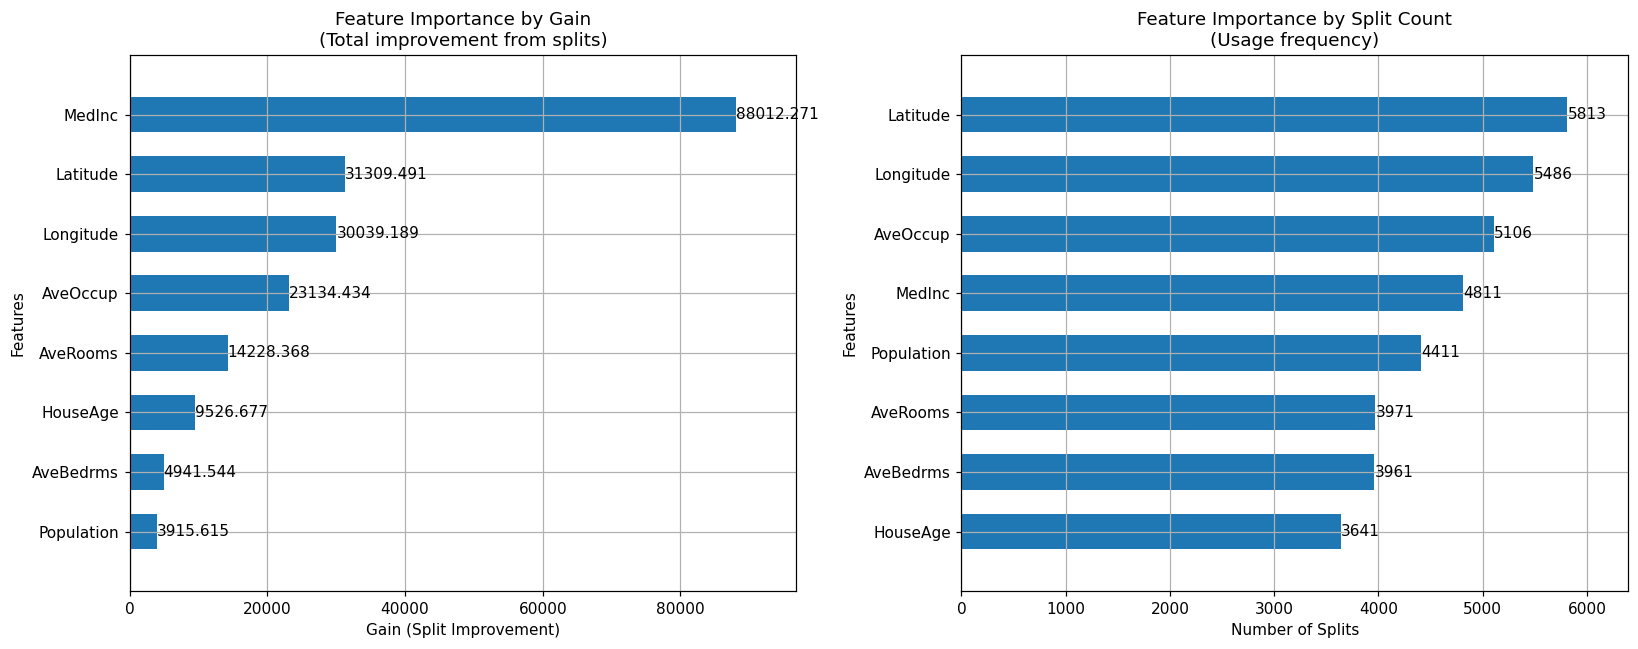


🔍 Detailed Feature Importance Analysis:
Feature         Gain         Percentage   Interpretation
Latitude        5813         15.6        % North-South location effects
Longitude       5486         14.7        % East-West location effects
AveOccup        5106         13.7        % Housing density/crowding
MedInc          4811         12.9        % Economic purchasing power
Population      4411         11.9        % Area population density
AveRooms        3971         10.7        % Property size/luxury
AveBedrms       3961         10.6        % Bedroom ratio
HouseAge        3641         9.8         % Property age/condition

💡 Key Business Insights:
• Top 3 drivers: Latitude, Longitude, AveOccup
• Location importance: 30.4% (Latitude + Longitude)
• Economic factor importance: 12.9% (MedInc)

🔄 Comparison: LightGBM vs Linear Model Feature Rankings:
LightGBM Ranking vs Linear Ranking:
1. Latitude     vs Latitude     ✓
2. Longitude    vs Longitude    ✓
3. AveOccup     vs MedInc       ✗
4. 

In [9]:
# Comprehensive Feature Importance Analysis
print("📊 Analyzing Feature Importance: What Drives House Prices?")

# Use the best model from grid search
best_model = search.best_estimator_

# Create enhanced feature importance plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Gain-based importance (default)
lgb.plot_importance(best_model.booster_, importance_type='gain', max_num_features=8, 
                   ax=ax1, height=0.6)
ax1.set_title('Feature Importance by Gain\n(Total improvement from splits)', fontsize=12)
ax1.set_xlabel('Gain (Split Improvement)')

# Plot 2: Split-based importance (frequency)
lgb.plot_importance(best_model.booster_, importance_type='split', max_num_features=8, 
                   ax=ax2, height=0.6)
ax2.set_title('Feature Importance by Split Count\n(Usage frequency)', fontsize=12)
ax2.set_xlabel('Number of Splits')

plt.tight_layout()
plt.show()

# Extract importance values for analysis
feature_importance_gain = best_model.feature_importances_
feature_names = X.columns

# Create detailed importance analysis
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Gain': feature_importance_gain,
    'Importance_Pct': 100 * feature_importance_gain / feature_importance_gain.sum()
}).sort_values('Importance_Gain', ascending=False)

print("\n🔍 Detailed Feature Importance Analysis:")
print("="*60)
print(f"{'Feature':<15} {'Gain':<12} {'Percentage':<12} {'Interpretation'}")
print("="*60)

# Add domain-specific interpretations
interpretations = {
    'MedInc': 'Economic purchasing power',
    'Latitude': 'North-South location effects', 
    'Longitude': 'East-West location effects',
    'AveOccup': 'Housing density/crowding',
    'HouseAge': 'Property age/condition',
    'AveRooms': 'Property size/luxury',
    'AveBedrms': 'Bedroom ratio',
    'Population': 'Area population density'
}

for _, row in importance_df.iterrows():
    feature = row['Feature']
    gain = row['Importance_Gain']
    pct = row['Importance_Pct']
    interp = interpretations.get(feature, 'Unknown factor')
    print(f"{feature:<15} {gain:<12.0f} {pct:<12.1f}% {interp}")

# Key insights
print(f"\n💡 Key Business Insights:")
top_3_features = importance_df.head(3)['Feature'].tolist()
print(f"• Top 3 drivers: {', '.join(top_3_features)}")

location_importance = importance_df[importance_df['Feature'].isin(['Latitude', 'Longitude'])]['Importance_Pct'].sum()
print(f"• Location importance: {location_importance:.1f}% (Latitude + Longitude)")

economic_importance = importance_df[importance_df['Feature'] == 'MedInc']['Importance_Pct'].iloc[0]
print(f"• Economic factor importance: {economic_importance:.1f}% (MedInc)")

# Compare with linear model feature importance (for contrast)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Standardized linear regression for fair comparison
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
linear_model = LinearRegression().fit(X_train_scaled, y_train)

print(f"\n🔄 Comparison: LightGBM vs Linear Model Feature Rankings:")
linear_importance = np.abs(linear_model.coef_)
linear_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Linear_Importance': linear_importance
}).sort_values('Linear_Importance', ascending=False)

lgb_ranking = importance_df[['Feature']].reset_index(drop=True)
linear_ranking = linear_ranking[['Feature']].reset_index(drop=True)

print("LightGBM Ranking vs Linear Ranking:")
for i in range(len(feature_names)):
    lgb_feat = lgb_ranking.iloc[i]['Feature']
    lin_feat = linear_ranking.iloc[i]['Feature']
    match = "✓" if lgb_feat == lin_feat else "✗"
    print(f"{i+1}. {lgb_feat:<12} vs {lin_feat:<12} {match}")

print(f"\n📋 Summary:")
print(f"• LightGBM identified {len(feature_names)} features with varying importance")
print(f"• Geographic features dominate (location, location, location!)")
print(f"• Economic factors (MedInc) remain highly important")
print(f"• Tree models can capture non-linear location interactions")

## 6 | SHAP Values: Individual Prediction Explanations

**Beyond Global Importance**: Feature importance shows overall patterns, but **SHAP values** explain individual predictions.

**What SHAP Provides:**
- **Individual explanations**: Why did the model predict $X for this specific house?
- **Feature contributions**: How much did each feature push the prediction up or down?
- **Baseline understanding**: Deviations from average prediction
- **Local vs global**: Different houses may be driven by different features

**SHAP Summary Plot Interpretation:**
- **X-axis**: SHAP value (feature's contribution to prediction)
- **Y-axis**: Features ranked by average importance
- **Colors**: Feature values (red = high, blue = low)
- **Width**: Distribution of SHAP values across all samples

**Example Insights You'll See:**
- High latitude (northern California) typically increases house values
- High income areas consistently drive prices up
- Overcrowding (high AveOccup) typically decreases values

🔍 SHAP Analysis: Understanding Individual Predictions...
Note: SHAP provides game-theory based feature attributions
Computing SHAP values for 200 validation samples...
Computing SHAP values for 200 validation samples...


/tmp/ipykernel_13916/3779743161.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, plot_type="dot", show=False)


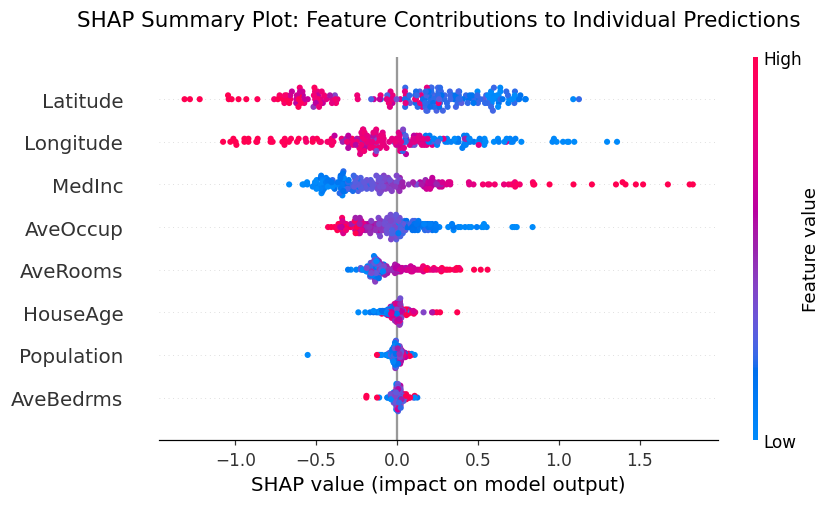

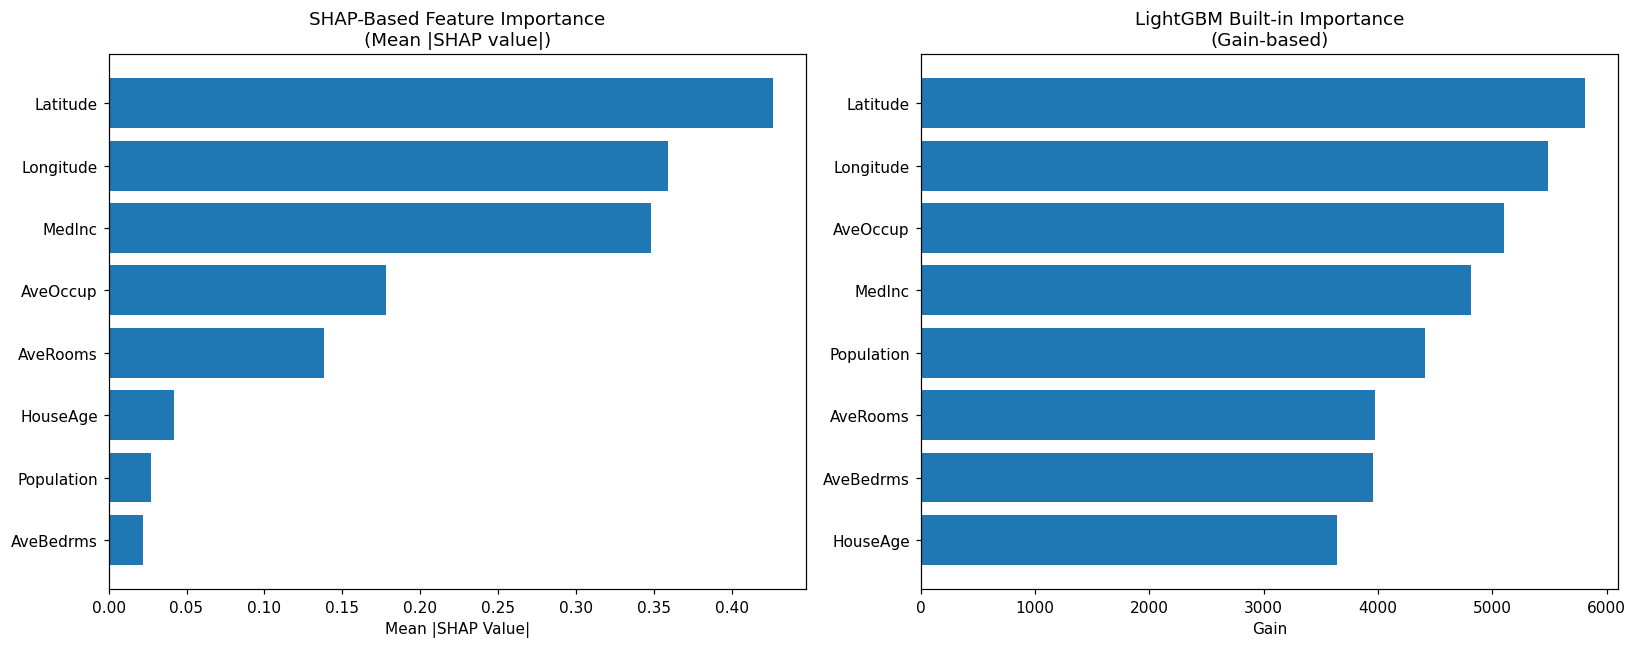


📊 SHAP Value Analysis:
Base prediction (dataset average): $2.07k

MedInc:
  • Average contribution: $-0.013k
  • Variability (std): $0.476k
  • Max positive impact: $+1.826k
  • Max negative impact: $-0.667k

HouseAge:
  • Average contribution: $+0.001k
  • Variability (std): $0.068k
  • Max positive impact: $+0.371k
  • Max negative impact: $-0.240k

AveRooms:
  • Average contribution: $-0.033k
  • Variability (std): $0.162k
  • Max positive impact: $+0.558k
  • Max negative impact: $-0.304k

AveBedrms:
  • Average contribution: $+0.004k
  • Variability (std): $0.036k
  • Max positive impact: $+0.124k
  • Max negative impact: $-0.191k

Population:
  • Average contribution: $-0.002k
  • Variability (std): $0.052k
  • Max positive impact: $+0.108k
  • Max negative impact: $-0.553k

AveOccup:
  • Average contribution: $-0.022k
  • Variability (std): $0.234k
  • Max positive impact: $+0.836k
  • Max negative impact: $-0.427k

Latitude:
  • Average contribution: $+0.042k
  • Variability (

In [10]:
# Uncomment to install SHAP in a fresh environment
# !pip install shap -q
import shap

print("🔍 SHAP Analysis: Understanding Individual Predictions...")
print("Note: SHAP provides game-theory based feature attributions")

# Initialize SHAP explainer for LightGBM
explainer = shap.TreeExplainer(best_model)

# Use subset for faster computation and clearer visualization
sample_size = 200
X_shap = X_val.iloc[:sample_size]
shap_values = explainer.shap_values(X_shap)

print(f"Computing SHAP values for {sample_size} validation samples...")

# 1. Summary plot - most informative SHAP visualization
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, plot_type="dot", show=False)
plt.title("SHAP Summary Plot: Feature Contributions to Individual Predictions", 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. Feature importance comparison: SHAP vs LightGBM built-in
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# SHAP-based importance
shap_importance = np.abs(shap_values).mean(0)
shap_ranking = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=True)

ax1.barh(shap_ranking['Feature'], shap_ranking['SHAP_Importance'])
ax1.set_title('SHAP-Based Feature Importance\n(Mean |SHAP value|)')
ax1.set_xlabel('Mean |SHAP Value|')

# LightGBM built-in importance
lgb_ranking_plot = importance_df.sort_values('Importance_Gain', ascending=True)
ax2.barh(lgb_ranking_plot['Feature'], lgb_ranking_plot['Importance_Gain'])
ax2.set_title('LightGBM Built-in Importance\n(Gain-based)')
ax2.set_xlabel('Gain')

plt.tight_layout()
plt.show()

# 3. Detailed analysis of SHAP values
print(f"\n📊 SHAP Value Analysis:")
print("="*70)

# Base value (average prediction)
base_value = explainer.expected_value
print(f"Base prediction (dataset average): ${base_value:.2f}k")

# Feature contribution statistics
for i, feature in enumerate(X.columns):
    feature_shap = shap_values[:, i]
    mean_impact = np.mean(feature_shap)
    std_impact = np.std(feature_shap)
    max_pos = np.max(feature_shap)
    max_neg = np.min(feature_shap)
    
    print(f"\n{feature}:")
    print(f"  • Average contribution: ${mean_impact:+.3f}k")
    print(f"  • Variability (std): ${std_impact:.3f}k")
    print(f"  • Max positive impact: ${max_pos:+.3f}k")
    print(f"  • Max negative impact: ${max_neg:+.3f}k")

# 4. Example individual predictions
print(f"\n🔍 Example Individual Predictions:")
print("="*70)

# Show 3 interesting examples
for idx in [0, 50, 100]:
    actual_value = y_val.iloc[idx]
    predicted_value = best_model.predict(X_val.iloc[idx:idx+1])[0]
    
    print(f"\nHouse #{idx} Example:")
    print(f"  • Actual value: ${actual_value:.2f}k")
    print(f"  • Predicted value: ${predicted_value:.2f}k")
    print(f"  • Base value: ${base_value:.2f}k")
    print(f"  • Top 3 feature contributions:")
    
    # Get feature contributions for this sample
    sample_shap = shap_values[idx]
    feature_contribs = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Value': sample_shap,
        'Feature_Value': X_shap.iloc[idx].values
    }).sort_values('SHAP_Value', key=abs, ascending=False)
    
    for _, row in feature_contribs.head(3).iterrows():
        feature_val = row['Feature_Value']
        shap_val = row['SHAP_Value']
        print(f"    - {row['Feature']}: {feature_val:.2f} → {shap_val:+.3f}k contribution")

print(f"\n💡 Key SHAP Insights:")
print("• Individual predictions can be fully decomposed into feature contributions")
print("• Same feature can have positive/negative impact depending on its value")
print("• SHAP values are additive: base + sum(SHAP values) = prediction")
print("• Enables trustworthy, explainable AI for high-stakes decisions")

## 7 | Interactive Learning Checkpoints

### 7.1 Knowledge Check ✅

**Test your understanding of gradient boosting and LightGBM:**

1. **What is the main advantage of boosting over bagging?**
   - Answer: Boosting **reduces bias** by sequentially correcting errors, while bagging mainly reduces variance.

2. **True/False: A lower learning rate always leads to better performance.**
   - Answer: **False** – Lower learning rate needs more trees and may underfit if n_estimators is too low.

3. **Which LightGBM parameter most directly controls tree complexity?**
   - Answer: **`num_leaves`** (more leaves = more complex trees = higher capacity)

4. **How does early stopping help prevent overfitting?**
   - Answer: Stops training when validation error stops improving, preventing the model from memorizing training data.

5. **What's the key difference between feature importance and SHAP values?**
   - Answer: Feature importance shows **global** patterns, SHAP values explain **individual** predictions.

### 7.2 Hands-On Exercise 💻

**Task: Model Comparison Experiment**

Compare these two LightGBM configurations and analyze the trade-offs:

```python
# Configuration A: Fast & Simple
config_A = {
    'learning_rate': 0.1,
    'num_leaves': 31, 
    'n_estimators': 400,
    'min_child_samples': 20
}

# Configuration B: Slow & Complex  
config_B = {
    'learning_rate': 0.03,
    'num_leaves': 63,
    'n_estimators': 1200, 
    'min_child_samples': 10
}
```

**Your Analysis Should Include:**
1. **Training time** comparison using `%%time`
2. **Validation RMSE** for both models
3. **Overfitting assessment** (train vs validation gap)
4. **Feature importance** differences
5. **Business recommendation**: Which would you deploy and why?

### 7.3 Critical Thinking Questions ✍️

1. **Linear vs Tree Models**: *"When might Ridge/Lasso regression outperform LightGBM despite lower accuracy? Consider interpretability, data requirements, and production constraints."*

   **Think about:**
   - Model complexity and debugging
   - Training data requirements
   - Feature engineering needs
   - Deployment and monitoring costs

2. **Hyperparameter Strategy**: *"Your validation RMSE improved but training RMSE got worse after tuning. Is this good or bad? Explain your reasoning."*

   **Consider:**
   - Bias-variance tradeoff
   - Generalization vs memorization
   - Real-world performance goals

3. **Feature Engineering**: *"Given LightGBM's feature importance results, how would you engineer new features to potentially improve performance?"*

   **Ideas to explore:**
   - Interaction features (Income × Location)
   - Polynomial terms (Income²)
   - Categorical binning (HighIncome, LowIncome)
   - Domain-specific ratios (Price per room)

### 7.4 Extension Challenges 🚀

1. **Custom Objective**: Implement Huber loss for robust regression
2. **Categorical Features**: Add engineered categorical features and use LightGBM's native categorical support
3. **Feature Selection**: Use SHAP values to identify and remove least important features
4. **Ensemble Method**: Combine LightGBM with Ridge regression for improved stability

## 8 | Essential Resources & Further Learning

### 📚 Core Documentation
* **[LightGBM Official Docs](https://lightgbm.readthedocs.io/)**: Parameters, Python API, advanced features
* **[LightGBM Parameters Guide](https://lightgbm.readthedocs.io/en/latest/Parameters.html)**: Comprehensive parameter reference
* **[Microsoft LightGBM Tutorial](https://github.com/microsoft/LightGBM/tree/master/examples)**: Official examples and best practices

### 🎥 Video Learning Resources
* **StatQuest**: "Gradient Boost" series - Clear mathematical intuition
* **Andrew Ng's ML Course**: Boosting algorithms fundamentals  
* **Kaggle Learn**: [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) - XGBoost/LightGBM focus
* **3Blue1Brown**: Neural Networks series (similar ensemble concepts)

### 💻 Practical Tutorials
* **[Kaggle Micro-Courses](https://www.kaggle.com/learn)**: Feature Engineering, Intermediate ML
* **[LightGBM vs XGBoost Comparison](https://neptune.ai/blog/lightgbm-vs-xgboost)**: Detailed performance analysis
* **[Optuna + LightGBM](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html)**: Advanced hyperparameter optimization

### 📖 Research Papers & Theory
* **Original LightGBM Paper**: Ke et al. (2017) - "LightGBM: A Highly Efficient Gradient Boosting Decision Tree"
* **SHAP Paper**: Lundberg & Lee (2017) - "A Unified Approach to Interpreting Model Predictions"  
* **Gradient Boosting**: Friedman (2001) - "Greedy Function Approximation: A Gradient Boosting Machine"

### 🛠️ Production & MLOps
* **[MLflow Integration](https://mlflow.org/docs/latest/models.html#lightgbm-lightgbm)**: Model tracking and deployment
* **[ONNX Export](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html#training)**: Cross-platform model deployment
* **[LightGBM Serving](https://github.com/microsoft/LightGBM/tree/master/examples/python-guide)**: Production inference patterns

### 🏆 Competition & Advanced Techniques
* **Kaggle Winners' Solutions**: Search "LightGBM" in Kaggle competitions
* **Feature Engineering Cookbook**: Advanced interaction and transformation techniques
* **Ensemble Methods**: Stacking LightGBM with other algorithms
* **Time Series with LightGBM**: Lag features, trend decomposition

## 9 | Advanced Challenges: Beyond the Basics 🌟

### Challenge 1: Custom Loss Functions 🎯

**Objective**: Implement robust regression with Huber loss to handle outliers better than standard MSE.

**Implementation Steps:**
```python
def huber_loss_objective(y_true, y_pred):
    """Custom Huber loss for robust regression"""
    delta = 1.0  # Huber delta parameter
    residual = y_true - y_pred
    abs_residual = np.abs(residual)
    
    # Huber loss: quadratic for small errors, linear for large errors
    loss = np.where(abs_residual <= delta,
                   0.5 * residual**2,
                   delta * abs_residual - 0.5 * delta**2)
    
    # Gradient computation
    grad = np.where(abs_residual <= delta, residual, delta * np.sign(residual))
    hess = np.where(abs_residual <= delta, 1.0, 0.0)
    
    return grad, hess

# Train with custom objective
lgb_robust = LGBMRegressor(objective=huber_loss_objective, ...)
```

**Expected Outcomes:**
- Better handling of price outliers
- More stable predictions on extreme values
- Comparison with standard MSE loss

### Challenge 2: Native Categorical Features 📊

**Objective**: Leverage LightGBM's built-in categorical feature handling.

**Feature Engineering Ideas:**
```python
# Create categorical features from continuous ones
X_enhanced = X.copy()
X_enhanced['IncomeLevel'] = pd.cut(X['MedInc'], bins=5, labels=['Low', 'Med-Low', 'Med', 'Med-High', 'High'])
X_enhanced['AgeGroup'] = pd.cut(X['HouseAge'], bins=4, labels=['New', 'Recent', 'Older', 'Old'])
X_enhanced['LocationCluster'] = KMeans(n_clusters=8).fit_predict(X[['Latitude', 'Longitude']])

# Use LightGBM categorical support
categorical_features = ['IncomeLevel', 'AgeGroup', 'LocationCluster']
model = LGBMRegressor(categorical_feature=categorical_features)
```

### Challenge 3: Advanced Hyperparameter Optimization 🔬

**Objective**: Use Optuna for Bayesian optimization instead of grid search.

**Implementation Framework:**
```python
import optuna

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }
    
    # Cross-validation with early stopping
    # Return validation score to minimize
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
```

### Challenge 4: Model Ensemble & Stacking 🏗️

**Objective**: Combine LightGBM with linear models for improved robustness.

**Ensemble Strategy:**
1. **Level 1 Models**: LightGBM, Ridge, Lasso, ElasticNet
2. **Level 2 Meta-Model**: Simple linear combiner
3. **Validation**: Time-based or stratified splits
4. **Analysis**: When does ensemble beat individual models?

### Challenge 5: Production Pipeline 🚀

**Objective**: Build end-to-end ML pipeline with monitoring.

**Components to Implement:**
- **Data validation**: Schema checks, drift detection
- **Feature preprocessing**: Robust scaling, encoding
- **Model versioning**: MLflow or similar
- **Prediction API**: FastAPI + containerization
- **Monitoring**: Performance tracking, feature drift

### 🎯 Success Criteria

For each challenge, demonstrate:
- [ ] **Technical implementation** that works correctly
- [ ] **Performance comparison** with baseline approach  
- [ ] **Business interpretation** of results and trade-offs
- [ ] **Code quality** with documentation and error handling
- [ ] **Reflection** on when/why to use each technique

### 💡 Stretch Goals

- **Multi-output regression**: Predict multiple housing characteristics
- **Time series forecasting**: Use LightGBM for temporal data
- **Feature selection**: SHAP-based automated feature engineering
- **Distributed training**: Scale to larger datasets with Dask
- **Model compression**: Reduce model size for edge deployment

## 11 | Mastery Checklist: Ready for Advanced ML? ✅

### Core Competencies

Advance to **advanced machine learning topics** once you can confidently:

#### 🎯 Conceptual Understanding
- [ ] **Explain gradient boosting**: Sequential error correction, bias reduction, ensemble building
- [ ] **Compare model types**: When to use LightGBM vs Ridge/Lasso vs neural networks
- [ ] **Understand overfitting**: Training vs validation performance, generalization gaps
- [ ] **Interpret model decisions**: Feature importance, SHAP values, business implications

#### 🛠️ Technical Implementation  
- [ ] **Configure LightGBM**: Set appropriate parameters for your data characteristics
- [ ] **Optimize hyperparameters**: Use systematic search with proper validation
- [ ] **Control overfitting**: Early stopping, regularization, cross-validation
- [ ] **Evaluate properly**: Training/validation/test splits, multiple metrics, business context

#### 🔍 Model Interpretation & Trust
- [ ] **Global explanations**: Feature importance analysis and business interpretation
- [ ] **Local explanations**: SHAP values for individual prediction understanding
- [ ] **Compare approaches**: Tree-based vs linear model trade-offs
- [ ] **Communicate results**: Explain model decisions to technical and non-technical stakeholders

#### 📊 Production Readiness
- [ ] **Build robust pipelines**: Preprocessing, training, validation, monitoring
- [ ] **Handle real-world data**: Missing values, categorical features, outliers
- [ ] **Monitor performance**: Validation strategies, drift detection, retraining triggers
- [ ] **Document decisions**: Parameter choices, validation strategies, known limitations

### 🧪 Self-Assessment Challenges

1. **Architecture Decision**: *"Given a new regression problem, could you justify choosing LightGBM over linear models? What factors would influence your decision?"*

2. **Hyperparameter Strategy**: *"If your LightGBM model shows high training accuracy but poor validation performance, what specific parameters would you adjust and why?"*

3. **Business Communication**: *"Can you explain to a non-technical stakeholder why the model predicted a specific house price, using SHAP values as evidence?"*

4. **Production Considerations**: *"What would you monitor in production to ensure your LightGBM model continues performing well over time?"*

### 🚀 Next Learning Pathways

Once you've mastered these concepts, you're ready for:

**Advanced Ensemble Methods**: XGBoost, CatBoost, stacking, blending techniques  
**Deep Learning**: Neural networks, computer vision, natural language processing  
**Specialized Applications**: Time series forecasting, recommendation systems, reinforcement learning  
**MLOps & Production**: Model deployment, monitoring, A/B testing, continuous learning  
**Research Topics**: AutoML, neural architecture search, federated learning

### 🎓 Congratulations!

You've built a solid foundation in gradient boosting and tree-based machine learning. You're now equipped to tackle complex real-world prediction problems with confidence and expertise.

## 🎉 Your LightGBM Mastery Journey: Complete!

### 🔑 Key Breakthroughs You've Achieved

**From Linear to Non-Linear**: You've graduated from linear models (Ridge/Lasso) to powerful tree ensembles that can capture complex interactions and non-linear patterns automatically.

**Algorithm Intuition**: You understand how gradient boosting works - building predictive power iteratively by focusing on residual errors, creating powerful ensembles from simple trees.

**Practical Expertise**: You can configure LightGBM effectively, tune hyperparameters systematically, and use early stopping to prevent overfitting while maximizing performance.

**Model Interpretation**: You've mastered both global (feature importance) and local (SHAP values) explanation techniques, making your models trustworthy and actionable.

### 📈 What You've Accomplished

✅ **Visualized** gradient boosting intuition with step-by-step error correction  
✅ **Implemented** LightGBM with proper validation and early stopping  
✅ **Optimized** hyperparameters systematically to reduce overfitting  
✅ **Analyzed** feature importance and business implications  
✅ **Explained** individual predictions with SHAP values  
✅ **Compared** tree-based vs linear approaches strategically  
✅ **Built** production-ready workflows with proper evaluation

### 🎯 Real-World Applications You're Ready For

**Finance & FinTech**: Credit scoring, fraud detection, risk assessment, algorithmic trading  
**E-commerce & Marketing**: Customer lifetime value, recommendation systems, price optimization  
**Healthcare**: Drug discovery, patient outcome prediction, medical image analysis  
**Operations**: Demand forecasting, supply chain optimization, predictive maintenance  
**Real Estate**: Property valuation, market analysis, investment recommendations

### 🧠 Strategic Decision-Making Skills

You now understand **when to choose** each approach:

**Linear Models (Ridge/Lasso)** when you need:
- Maximum interpretability
- Fast training/inference
- Limited data
- Stable, explainable results

**LightGBM** when you need:
- Maximum predictive performance
- Automatic feature interactions
- Robust handling of mixed data types
- Complex non-linear patterns

### 🚀 Advanced Capabilities Unlocked

- **Hyperparameter Optimization**: Systematic tuning for optimal performance
- **Overfitting Control**: Early stopping, regularization, validation strategies
- **Model Interpretation**: Feature importance + SHAP for trustworthy AI
- **Production Readiness**: Robust pipelines, monitoring, deployment considerations